# 1. Introduction

Nikki Satmaka - Batch 11

## Description

Dataset is taken from [Google Cloud Platform ftds-hacktiv8](https://console.cloud.google.com/bigquery?p=ftds-hacktiv8-project&d=phase1_assignments&t=heart-failure&page=table)

Context:
Cardiovascular diseases kill approximately 17 million people globally every year, and they mainly exhibit as myocardial infarctions and heart failures

This dataset contains the medical records of 299 heart failure patients collected at the Faisalabad Institute of Cardiology and at the Allied Hospital in Faisalabad (Punjab, Pakistan), during April–December 2015. The patients consisted of 105 women and 194 men, and their ages range between 40 and 95 years old

List of features:
1. `age` : Age
2. `anaemia` : Decrease of red blood cells or hemoglobin (boolean)
3. `creatinine_phosphokinase` : Level of the CPK enzyme in the blood (mcg/L)
4. `diabetes` : If the patient has diabetes (boolean)
5. `ejection_fraction` : Percentage of blood leaving the heart at each contraction (percentage)
6. `high_blood_pressure` : If the patient has hypertension (boolean)
7. `platelets` : Platelets in the blood (kiloplatelets/mL)
8. `serum_creatinine` : Level of serum creatinine in the blood (mg/dL)
9. `serum_sodium` : Level of serum sodium in the blood (mEq/L)
10. `sex` : Woman or man (binary)
11. `smoking` : If the patient smokes or not (boolean)
12. `time` : Follow-up period (days)
13. `DEATH_EVENT` : If the patient deceased during the follow-up period (boolean)


### Objective

- Predict if the patient would pass away during the follow-up period

### Problem Statement

- What features are going to be useful as predictors?

### Additional Information
- [Dataset Explanation](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5/tables/1)

### Data Collection

We first need to query our data from GCP's BiqQuery using this code

```SQL
SELECT *
FROM `ftds-hacktiv8-project.phase1_assignments.heart-failure`
```

# 2. Importing Libraries

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from pathlib import Path

from pandas_profiling import ProfileReport

import joblib

import warnings
warnings.filterwarnings('ignore')

# For Handling outlier
from feature_engine.outliers import OutlierTrimmer
from feature_engine.outliers import Winsorizer
from feature_engine.outliers import ArbitraryOutlierCapper

# For Handling Missing Values
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import RandomSampleImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import ArbitraryNumberImputer

# For Data Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# For Classification Problems
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Split Dataset and Standarize the Datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler

# Evaluate Classification Models
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score


pd.set_option('display.precision', 2)

sns.set_theme(style='darkgrid', palette='deep')

%matplotlib inline

### Useful Functions

In [2]:
def check_unique(data, col_type='both'):
    """
    Count the number of unique values in each features for 'numeric', 'categorical', or 'both'

    Parameters
    ----------
    data : DataFrame

    col_type : str
        The type of the column to filter. Either 'number', 'object', or 'both'

    Returns
    -------
    DataFrame
        Number of unique values of each features
    """

    # check if the column type is valid
    if col_type not in ('number', 'object', 'both'):
        raise ValueError('col_type must be either "number", "object", or "both"')

    # create a list if the column type is 'both'
    if col_type == 'both':
        col_type = ['number', 'object']

    # get the number of unique values in each column
    data_unique_count = pd.DataFrame.from_records(
        [(col, data[col].nunique()) for col in data.select_dtypes(include=col_type).columns],
        columns=['feats', 'num_unique']
    )

    return data_unique_count

In [3]:
def find_normal_boundaries(data, variable):
    """
    Calculate the boundaries outside which sit the outliers for a Gaussian distribution

    Parameters
    ----------
    data : DataFrame

    variable : string
        The feature of the DataFrame in which to the calculation will be performed

    Returns
    -------
    upper_boundary : float
        The computed upper boundary of the data

    lower_boundary : float
        The computed lower boundary of the data
    """

    upper_boundary = data[variable].mean() + 3 * data[variable].std()
    lower_boundary = data[variable].mean() - 3 * data[variable].std()

    return upper_boundary, lower_boundary

In [4]:
def find_skewed_boundaries(data, variable, distance):
    """
    Calculate the boundaries outside which sit the outliers for skewed distribution

    Parameters
    ----------
    data : DataFrame

    variable : string
        The feature of the DataFrame in which to the calculation will be performed

    distance : float
        The distance multiplier of IQR to calculate the boundaries

    Returns
    -------
    upper_boundary : float
        The computed upper boundary of the data

    lower_boundary : float
        The computed lower boundary of the data
    """

    IQR = data[variable].quantile(0.75) - data[variable].quantile(0.25)

    upper_boundary = data[variable].quantile(0.75) + (IQR * distance)
    lower_boundary = data[variable].quantile(0.25) - (IQR * distance)

    return upper_boundary, lower_boundary

In [5]:
def check_dist(data):
    """
    Check the Skewness and Distribution for each features in a dataset

    Parameters
    ----------
    data : DataFrame

    Returns
    -------
    DataFrame
        Skewness and distribution types of each features
    """

    # create a DataFrame containing the features of the dataset and their respective skewness
    data_skewness = pd.DataFrame(data.skew(), columns=['skew']).reset_index()

    # reset the index and make the features columns
    data_skewness = data_skewness.rename(columns={'index': 'feats'})

    # create a new column to describe whether the feature in the dataset is normal or skewed
    data_skewness['dist'] = np.where(
        (data_skewness['skew'] > -0.5) & (data_skewness['skew'] < 0.5),
        'normal',
        'skewed'
    )

    return data_skewness

In [6]:
def check_outlier(data, distance=1.5):
    """
    Check the outlier info for each features in a dataset

    Parameters
    ----------
    data : DataFrame

    distance : float
        The distance multiplier of IQR to calculate the boundaries for skewed distributions. It's either 1.5 or 3

    Returns
    -------
    DataFrame
        Outlier infos such as upper and lower boundary, and also the number of outliers for each features
    """

    if distance not in (1.5, 3):
        raise ValueError('Parameter distance only accepts numeric value of either 1.5 or 3')

    data_skewness = check_dist(data)

    # create a dictionary to store the outlier infos
    data_outlier = {
        'feats': [],
        'upper_bound': [],
        'lower_bound': [],
        'tot_right_tail': [],
        'tot_left_tail': [],
        'tot_right_tail_pct': [],
        'tot_left_tail_pct': [],
        'tot_outlier': [],
        'tot_outlier_pct': [],
    }

    # loop over each row in the `skewness` DataFrame
    # calculate each features upper and lower boundaries and the outlier percentage
    for row in data_skewness.index:
        col = data_skewness.iloc[row]['feats']

        if data_skewness.iloc[row]['dist'] == 'normal':
            upper_bound, lower_bound = find_normal_boundaries(data, col)
        else:
            upper_bound, lower_bound = find_skewed_boundaries(data, col, distance)

        tot_right_tail = len(data[data[col] > upper_bound])
        tot_left_tail = len(data[data[col] < lower_bound])
        tot_right_tail_pct = tot_right_tail / len(data) * 100
        tot_left_tail_pct = tot_left_tail / len(data) * 100
        tot_outlier =  tot_right_tail + tot_left_tail
        tot_outlier_pct = tot_right_tail_pct + tot_left_tail_pct

        data_outlier['feats'].append(col)
        data_outlier['upper_bound'].append(upper_bound)
        data_outlier['lower_bound'].append(lower_bound)
        data_outlier['tot_right_tail'].append(tot_right_tail)
        data_outlier['tot_left_tail'].append(tot_left_tail)
        data_outlier['tot_right_tail_pct'].append(tot_right_tail_pct)
        data_outlier['tot_left_tail_pct'].append(tot_left_tail_pct)
        data_outlier['tot_outlier'].append(tot_outlier)
        data_outlier['tot_outlier_pct'].append(tot_outlier_pct)
    
    data_outlier = pd.DataFrame(data_outlier)

    return data_outlier

In [7]:
def outlier_summary(data, distance=1.5):
    """
    Check the summary for outlier data, such as distribution and number of outliers for each features

    Parameters
    ----------
    data : DataFrame

    distance : float
        The distance multiplier of IQR to calculate the boundaries for skewed distributions. It's either 1.5 or 3

    Returns
    -------
    DataFrame
        Summary of outlier such as distribution and number of outliers for each features
    """

    data_skewness = check_dist(data)
    data_outlier = check_outlier(data, distance)

    outlier_summary_cols = ['feats', 'skew', 'dist', 'tot_outlier', 'tot_outlier_pct']

    data_outlier_summary = pd.merge(data_skewness, data_outlier, on=['feats'])
    data_outlier_summary = data_outlier_summary[outlier_summary_cols]

    return data_outlier_summary

In [8]:
def impute_na(data, variable, mean_value, median_value):
  """
  Function to Fill Missing Values with Zeroes, Mean, and Median
  """
  data[variable+'_mean'] = data[variable].fillna(mean_value)
  data[variable+'_median'] = data[variable].fillna(median_value)
  data[variable+'_zero'] = data[variable].fillna(0)
  
  return data

# 3. Data Loading

In [9]:
# load dataset
df_ori = pd.read_csv('data/h8dsft_P1G3_nikki_satmaka.csv')
df = df_ori.copy()

# display the first 5 entries of the data
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,42.0,1,250,1,15,0,213000.0,1.3,136,0,0,65,1
1,46.0,0,168,1,17,1,271000.0,2.1,124,0,0,100,1
2,65.0,1,160,1,20,0,327000.0,2.7,116,0,0,8,1
3,53.0,1,91,0,20,1,418000.0,1.4,139,0,0,43,1
4,50.0,1,582,1,20,1,279000.0,1.0,134,0,0,186,0


In [10]:
# display the last 5 entries of the data
df.tail()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
294,63.0,1,122,1,60,0,267000.00,1.2,145,1,0,147,0
295,45.0,0,308,1,60,1,377000.00,1.0,136,1,0,186,0
296,70.0,0,97,0,60,1,220000.00,0.9,138,1,0,186,0
297,53.0,1,446,0,60,1,263358.03,1.0,139,1,0,215,0
298,50.0,0,582,0,62,1,147000.00,0.8,140,1,1,192,0


## Data Understanding

In [11]:
# check dataset shape
df.shape

(299, 13)

There are 299 entries and 13 columns of data.\
We do not have a lot of data

In [12]:
# check dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


All data types are number

In [13]:
# check missing values in dataset
df.isna().sum().sort_values(ascending=False)

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

Great there are no missing values

## Basic Characteristics of the Dataset

In [14]:
# check basic stats for numerical features
df.describe(percentiles=[0.5]).T

,count,mean,std,min,50%,max
age,299.0,60.83,11.89,40.0,60.0,95.0
anaemia,299.0,0.43,0.50,0.0,0.0,1.0
creatinine_phosphokinase,299.0,581.84,970.29,23.0,250.0,7861.0
diabetes,299.0,0.42,0.49,0.0,0.0,1.0
ejection_fraction,299.0,38.08,11.83,14.0,38.0,80.0
high_blood_pressure,299.0,0.35,0.48,0.0,0.0,1.0
platelets,299.0,263358.03,97804.24,25100.0,262000.0,850000.0
serum_creatinine,299.0,1.39,1.03,0.5,1.1,9.4
serum_sodium,299.0,136.63,4.41,113.0,137.0,148.0
sex,299.0,0.65,0.48,0.0,1.0,1.0


In [15]:
# check the cardinality of each nominal and ordinal features
for col in df.columns:
    if df[col].nunique() < 15:
        print(col, ':', df[col].nunique(), 'unique values, which contains', np.sort(df[col].unique()))

anaemia : 2 unique values, which contains [0 1]
diabetes : 2 unique values, which contains [0 1]
high_blood_pressure : 2 unique values, which contains [0 1]
sex : 2 unique values, which contains [0 1]
smoking : 2 unique values, which contains [0 1]
DEATH_EVENT : 2 unique values, which contains [0 1]


Let's cover some of the columns of this dataset
- `age`
    - Ranges from 40 to 95
    - Interval feature
    - Mean is only slightly higer than the median
    - Might be normally distributed
- `anaemia`
    - Nominal feature
    - Since it's either 0 or 1 and the median of the data is 0, the mode is also 0
    - Most of the patients do not have anaemia
- `creatinine_phosphokinase`
    - Ranges from 23 to 7861
    - Interval feature
    - Mean is way higher than the median by a long shot
    - Data is heavily right skewed
- `diabetes`
    - Nominal feature
    - Since it's either 0 or 1 and the median of the data is 0, the mode is also 0
    - Most patients do not have diabetes
- `ejection_fraction`
    - In percentages
    - Ranges from 14 to 80
    - Interval feature
    - Mean is only slightly higer than the median
    - Might be normally distributed
- `high_blood_pressure`
    - Nominal feature
    - Since it's either 0 or 1 and the median of the data is 0, the mode is also 0
    - Most patients do not have high blood pressure
- `platelets`
    - in kiloplatelets/mL
    - Ranges from 25,100 to 850,000
    - Interval feature
    - The mean is only slightly higher than the median
    - Might be normally distributed
- `serum_creatinine`
    - Ranges from 0.5 to 9.4
    - Interval feature
    - The mean is higher than the median
    - Might be right skewed
- `serum_sodium`
    - Ranges from 113 to 148
    - Interval feature
    - The mean is higher than the median
    - Might be right skewed
- ` sex`
    - Nominal feature
    - 0 for woman and 1 for man
    - Since it's either 0 or 1 and the median of the data is 1, the mode is also 1
    - Most patients are man
- `smoking`
    - Nominal feature
    - Since it's either 0 or 1 and the median of the data is 0, the mode is also 0
    - Most patients do not smoke
- `time`
    - In days
    - Ranges from 4 to 285 days
    - Mean is higher than the median
    - Might be right skewed
- `DEATH_EVENT`
    - Our target
    - Whether the patient died during the follow up period
    - Since it's either 0 or 1 and the median of the data is 0, the mode is also 0
    - Most patients did not die during the follow up period
    - I do not like how this column is written in caps, I'm going to make it lowercase

## Data Preparation

Make all columns in lowercase

In [16]:
df.columns = df.columns.str.lower()

print(df.columns.to_list())

['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time', 'death_event']


Looks great

## Check for Dataset Imbalance

Check whether the target variable of the dataset is balance

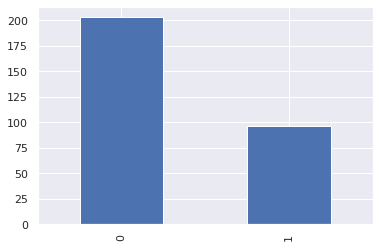

In [17]:
# check for imbalance in target variable
df['death_event'].value_counts().plot(kind='bar')
plt.show()

Since our dataset is imbalance, we need to stratify when splitting

## Splitting Dataset

We need to split the dataset into inference, train and test sets before we do any EDA.\
We do our EDA on the train set so as to not have any bias towards the whole dataset.

### Sample data for inference

In [18]:
# set random state
random_state = 42

In [19]:
# sample dataset for inference
df_inf = df.sample(10, random_state=random_state)

# remove inference set from original dataset
df_train_test = df.drop(df_inf.index).reset_index(drop=True)

# reset index for inference set
df_inf = df_inf.reset_index(drop=True)

print('df_inf Size:', df_inf.shape)

df_inf Size: (10, 13)


### Split train and test set


Since the target variable is imbalanced, we use stratified sampling

In [20]:
# we use stratified sampling to ensure that the distribution of the target variable is balanced
# we do not have a lot of data so we use 10% of the data for testing
df_train, df_test = train_test_split(
    df_train_test,
    test_size=0.20,
    random_state=random_state,
    stratify=df_train_test['death_event']
)

print('df_train Size:', df_train.shape)
print('df_test Size:', df_test.shape)

df_train Size: (231, 13)
df_test Size: (58, 13)


In [21]:
# backup the train set that we are gonna perform EDA on
df_train_ori = df_train.copy()

# 4. Exploratory Data Analysis

## Source of dataset

The dataset seems to have come from [BMC](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5)

## Distribution of follow up period for each death event

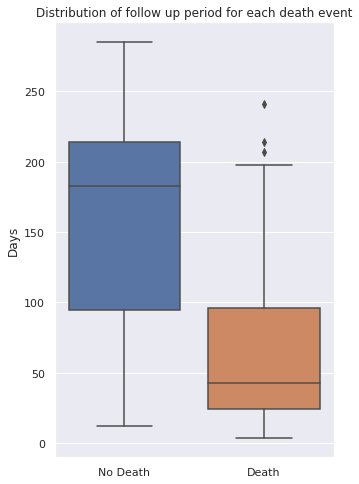

In [22]:
# plot the distribution of follow up period for each death event
plt.figure(figsize=(5, 8))
sns.boxplot(data=df_train, x='death_event', y='time')
plt.title('Distribution of follow up period for each death event')
plt.xlabel(None)
plt.ylabel('Days')
plt.xticks([0, 1], ['No Death', 'Death'])

plt.show()

We can see that the case of decease, happened mostly within the 50-day-mark. Most patients who did not pass away, survived and could attend the follow up period until around 200 days. I assume that after this safe mark, the follow up period is performed less frequently

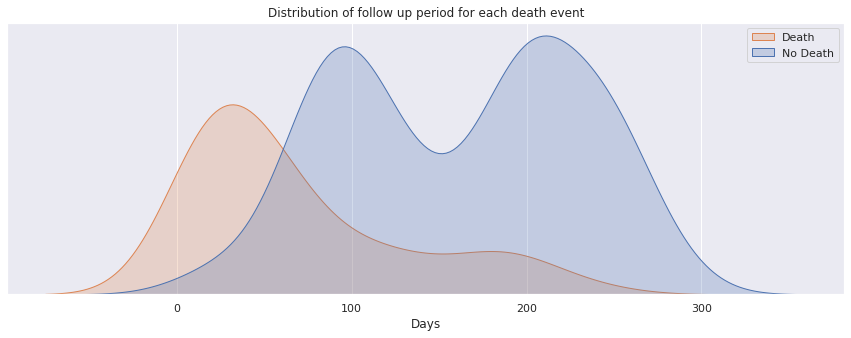

In [23]:
# plot the distribution of follow up period for each death event
plt.figure(figsize=(15, 5))
sns.kdeplot(data=df_train, x='time', hue='death_event', shade=True)
plt.title('Distribution of follow up period for each death event')
plt.xlabel('Days')
plt.ylabel(None)
plt.yticks([])

plt.legend(labels=['Death', 'No Death'])
plt.show()

We could see in more detail by plotting the time in the horizontal axis. The same insights for the deceased that it happens mostly around the 50-day-follow-up-period. There is however two bulges for the survivors, where they were followed up until around 100 days and 200 days. We could conclude that the crucial period to monitor is within those 50-day-period where the event of decease mostly happen

## Subheading 2

## Subheading 3

# 5. Data Preprocessing

In [24]:
# restore the train set from the backup
df_train = df_train_ori.copy()

In [25]:
# split between features and target
X_train = df_train.drop(['death_event'], axis=1)
y_train = df_train['death_event'].copy()

X_test = df_test.drop(['death_event'], axis=1)
y_test = df_test['death_event'].copy()

## Categorizing Features

Categorize the features based on the variable type of the features and the data it represents
- Numeric (Interval): Features which have equally spaced interval between unique values
- Categorical (Nominal): Features which have no intrinsic ordering to the unique values
- Ordinal: Features which have clear ordering but do not have equally spaced intervals between unique values

In [26]:
# categorizing features
num_cols = [
    'age',
    'creatinine_phosphokinase',
    'ejection_fraction',
    'platelets',
    'serum_creatinine',
    'serum_sodium',
    'time'
]

nom_cols = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

## Handling Outliers

In [27]:
# check outlier summary only on numerical features
outlier_summary(X_train[num_cols], 1.5)

,feats,skew,dist,tot_outlier,tot_outlier_pct
0,age,0.49,normal,0,0.00
1,creatinine_phosphokinase,5.04,skewed,20,8.66
2,ejection_fraction,0.69,skewed,26,11.26
3,platelets,0.94,skewed,14,6.06
4,serum_creatinine,4.56,skewed,20,8.66
5,serum_sodium,-0.96,skewed,2,0.87
6,time,0.10,normal,0,0.00


1. `Trimming`: if outliers' percentage < 5%
2. `Capping`: if outliers' percentage 5% - 15%
3. `None`: if outliers' percentage > 15%

In [28]:
# check outlier details
check_outlier(X_train[num_cols], 1.5)

,feats,upper_bound,lower_bound,tot_right_tail,tot_left_tail,tot_right_tail_pct,tot_left_tail_pct,tot_outlier,tot_outlier_pct
0,age,95.79,25.62,0,0,0.00,0.00,0,0.00
1,creatinine_phosphokinase,1285.50,-590.50,20,0,8.66,0.00,20,8.66
2,ejection_fraction,55.00,15.00,26,0,11.26,0.00,26,11.26
3,platelets,445500.00,69500.00,10,4,4.33,1.73,14,6.06
4,serum_creatinine,2.27,0.08,20,0,8.66,0.00,20,8.66
5,serum_sodium,149.00,125.00,0,2,0.00,0.87,2,0.87
6,time,370.85,-106.04,0,0,0.00,0.00,0,0.00


In [29]:
# outlier capping using winsorization
trim_cols = ['serum_sodium']
cap_cols = ['creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine']

### Outlier Trimming

In [30]:
# outlier trimming 
out_trimmer = OutlierTrimmer(
    capping_method='quantiles',
    tail='both',
    fold=0.05,
    variables=trim_cols,
    missing_values='ignore'
)

# # trim the train set
# X_train = out_trimmer.fit_transform(X_train)

# # adjust target to match train features
# y_train = y_train.drop(y_train.index.difference(X_train.index))

### Outlier Capping

In [31]:
# outlier capping 
out_capper = Winsorizer(
    capping_method='iqr',
    tail='both',
    fold=1.5,
    variables=cap_cols,
    missing_values='ignore'
)

# # cap the train set
# X_train = out_capper.fit_transform(X_train)

# # adjust target to match train features
# y_train = y_train.drop(y_train.index.difference(X_train.index))

In [32]:
# check final outlier summary
outlier_summary(X_train[num_cols], 1.5)

,feats,skew,dist,tot_outlier,tot_outlier_pct
0,age,0.49,normal,0,0.00
1,creatinine_phosphokinase,5.04,skewed,20,8.66
2,ejection_fraction,0.69,skewed,26,11.26
3,platelets,0.94,skewed,14,6.06
4,serum_creatinine,4.56,skewed,20,8.66
5,serum_sodium,-0.96,skewed,2,0.87
6,time,0.10,normal,0,0.00


## Handling Missing Values

In [33]:
# check missing values in train set
X_train.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
dtype: int64

In [34]:
# check missing values in train target
y_train.isna().sum()

0

In [35]:
# check missing values in test set
X_test.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
dtype: int64

In [36]:
# check missing values in test target
y_test.isna().sum()

0

Great! There are no missing values in train nor test features and target

## Feature Selection

### Heatmap Correlation Matrix for Numerical Features

We look at the Spearman's correlation matrix to find out the relation between features and target

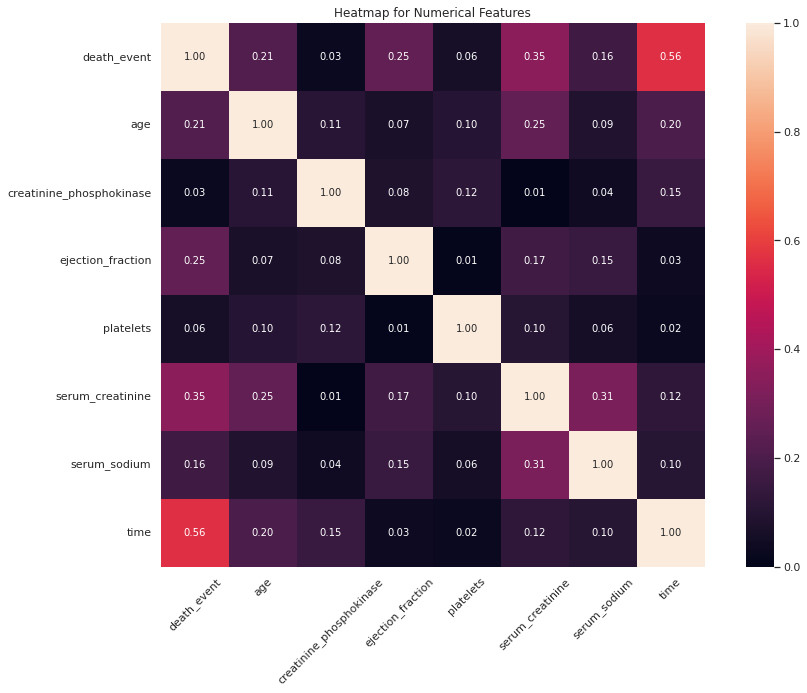

In [37]:
# Heatmap Correlation Matrix
plt.figure(figsize=(15,10))

sns.heatmap(
    pd.concat([y_train, X_train[num_cols]], axis=1).corr('spearman').abs(),
    annot=True, vmin=0, vmax=1, fmt='.2f', square=True)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Heatmap for Numerical Features')

plt.show()


- There are quite a high correlation between `time` and our target `death_event`
- There are some moderate correlation between `age`, `ejection_fraction`, `serum_creatinine`, `serum_sodium` and our target `death_event`
- There are no features that are highly correlated with each other
- For this research, I'm going to filter out features that have less than `0.20` Spearman's correlation value towards the target variable

### Heatmap Correlation Matrix for Categorical Features

We look at the Spearman's correlation matrix to find out the relation between features and target

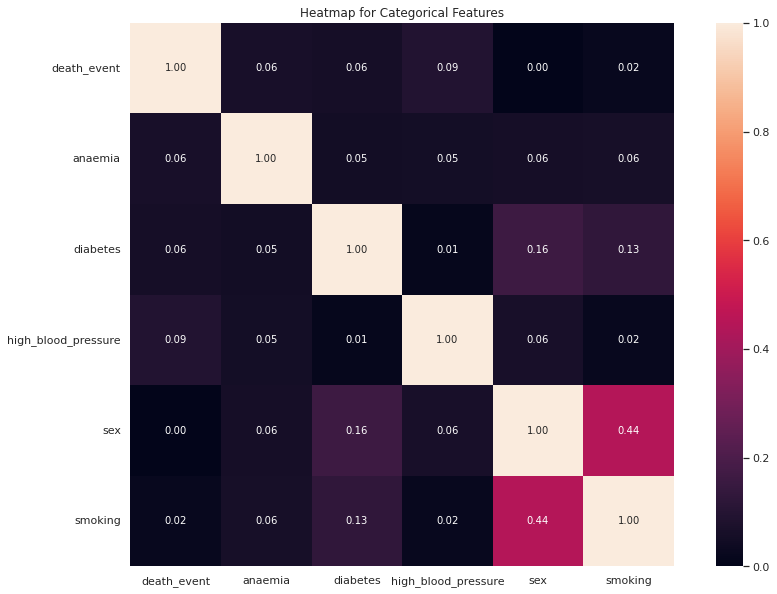

In [38]:
# Heatmap Correlation Matrix
plt.figure(figsize=(15,10))

sns.heatmap(
    pd.concat([y_train, X_train[nom_cols]], axis=1).corr('spearman').abs(),
    annot=True, vmin=0, vmax=1, fmt='.2f', square=True)
plt.yticks(rotation=0)
plt.title('Heatmap for Categorical Features')

plt.show()


- The correlations here are lower compared to the numerical features we have
- The highest correlation here is held by `high_blood_pressure`
- For this research, I'm going to drop all these categorical features since they have low correlation
- I've actually run multiple tests and the model performed better without them in terms of being a good fit and recall scores

In [39]:
# create list of numerical features with normal distribution
num_cols_norm = ['age', 'time']

# create list of numerical features with skew
num_cols_skew = [
    'ejection_fraction',
    'serum_creatinine'
]

# create final list of nominal features
nom_cols = []

Great! We have finalized our feature list.
We also separated numerical features with different types of distribution because they will be scaled differently

### List of Features

These are the predictors we're going to use

In [40]:
# print out list of predictors
print('Numerical Features:')
print(num_cols)
print('=' * 50)
print('Categorical Features:')
print(nom_cols)

Numerical Features:
['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
Categorical Features:
[]


Since all the nominal features are binaries, I **do not** need to encode it again using *OneHotEncoder*

### Create Pipeline

Create a pipeline based on how we would engineer the features, whether to scale or to encode
- We will create multiple pipeline for scaling because each features and each models require different procedures in which we handle it
- All categorical features will use one hot encoder

In [41]:
# create pipeline for standardization
std_pipe = Pipeline([
    ('std_scaler', StandardScaler())
])

# create pipeline for min max scaling
min_max_pipe = Pipeline([
    ('min_max_scaler', MinMaxScaler())
])

# create pipeline for normalizer
power_pipe = Pipeline([
    ('power_transformer', PowerTransformer())
])

# create pipeline for robust scaler
robust_pipe = Pipeline([
    ('robust_scaler', RobustScaler())
])

# create pipeline for categorical features
nom_pipe = Pipeline([
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

### Create Column Transformer

Create a `ColumnTransformer` object based on the pipeline we have created\
All normally distributed numerical features will use *StandardScaler*\
The rest will varied and tested

In [42]:
# create column transformer object using standard scaler
ct_std = ColumnTransformer([
    ('num_norm', std_pipe, num_cols_norm),
    ('num_skew', std_pipe, num_cols_skew),
    ('nom', 'passthrough', nom_cols)
])

# create column transformer object using min max scaler
ct_mm = ColumnTransformer([
    ('num_norm', std_pipe, num_cols_norm),
    ('num_skew', min_max_pipe, num_cols_skew),
    ('nom', 'passthrough', nom_cols)
])

# create column transformer object using power transform
ct_pt = ColumnTransformer([
    ('num_norm', std_pipe, num_cols_norm),
    ('num_skew', power_pipe, num_cols_skew),
    ('nom', 'passthrough', nom_cols)
])

# create column transformer object using robust scaler
ct_rs = ColumnTransformer([
    ('num_norm', std_pipe, num_cols_norm),
    ('num_skew', robust_pipe, num_cols_skew),
    ('nom', 'passthrough', nom_cols)
])


# 6. Model Definition

- Target: Predicting whether the patient would die within the follow up period


- Predictors: The features I'm going to use are

- Models: The Supervised Learning Algorithms I'm going to test

## Random Forest

In [43]:
# declare random forest classifier
rf = RandomForestClassifier(random_state=random_state)

# create pipeline for random forest classifier
rf_pipe = Pipeline([
    ('ct', ct_mm),
    ('rf', rf)
])


## Gradient Boosting

In [44]:
# declare gradient boosting classifier
gbc = GradientBoostingClassifier(random_state=random_state)

# create pipeline for gradient boosting classifier
gbc_pipe = Pipeline([
    ('ct', ct_mm),
    ('gbc', gbc)
])

# 7. Model Training

In [45]:
# create a dictionary of models
models = {
    'rf': rf_pipe,
    'gbc': gbc_pipe
}

## Cross Validating Base Models

Since the dataset is imbalance, we are going to evaluate our models based on **F1 Score**\
It's also important that we reduce the number of *False Negatives*, hence a high **Recall** is also important

In [46]:
# create a dict to store the cross validation scores
cv_results = {
    'models': [],
    'f1_score_mean': [],
    'f1_score_std': [],
    'recall_score_mean': [],
    'recall_score_std': []
} 

# loop over each each models and perform cross validation
for name, model in models.items():
    # fit the model
    model.fit(X_train, y_train)
    # get cross validation scores
    scores = cross_validate(
        model, X_train, y_train,
        scoring=['f1_weighted', 'recall'],
        cv=5
    )

    # store the cross validation scores
    cv_results['models'].append(name)
    cv_results['f1_score_mean'].append(scores['test_f1_weighted'].mean().round(2))
    cv_results['f1_score_std'].append(scores['test_f1_weighted'].std().round(4))
    cv_results['recall_score_mean'].append(scores['test_recall'].mean().round(2))
    cv_results['recall_score_std'].append(scores['test_recall'].std().round(4))

# create a dataframe from the dict
cv_results_df = pd.DataFrame(cv_results)

# 8. Model Evaluation

In [47]:
# display the dataframe sorted by f1 score and recall score
cv_results_df.sort_values(by=['f1_score_mean', 'recall_score_mean'], ascending=False)

,models,f1_score_mean,f1_score_std,recall_score_mean,recall_score_std
1,gbc,0.84,0.02,0.72,0.08
0,rf,0.83,0.03,0.71,0.05


## Hyperparameter Tuning


In [48]:
# create parameter grid for random forest classifier
params_rf = {
    'rf__max_depth': [3, 5, 7, 10, None],
    'rf__min_samples_leaf': [1, 2, 3, 4],
    'rf__min_samples_split': [2, 3, 4, 5],
}

In [49]:
# create parameter grid for gradient boosting classifier
params_gbc = {
    'gbc__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'gbc__max_depth': [3, 5, 7, 10, None],
    'gbc__min_samples_leaf': [1, 2, 3, 4],
}

In [50]:
# create grid search object for random forest classifier
rf_grid = GridSearchCV(
    rf_pipe,
    params_rf,
    cv=5,
    scoring='f1_weighted'
)

In [51]:
# create grid search object for gradient boosting classifier
gbc_grid = GridSearchCV(
    gbc_pipe,
    params_gbc,
    cv=5,
    scoring='f1_weighted'
)

In [52]:
# create randomized search object for random forest classifier
rf_rand = RandomizedSearchCV(
    rf_pipe,
    params_rf,
    cv=5,
    scoring='f1_weighted',
    n_iter=10
)

In [53]:
# create randomized search object for gradient boosting classifier
gbc_rand = RandomizedSearchCV(
    gbc_pipe,
    params_gbc,
    cv=5,
    scoring='f1_weighted',
    n_iter=10
)

In [54]:
%%time

# perform grid search for random forest classifier
rf_grid.fit(X_train, y_train)

CPU times: user 1min 2s, sys: 488 ms, total: 1min 2s
Wall time: 1min 2s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num_norm',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'time']),
                                                                        ('num_skew',
                                                                         Pipeline(steps=[('min_max_scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['ejection_fraction',
                                                                          'serum_creatinine']),
                                                                        ('nom',
                                                                         'passthrough',
                                                                         [])])),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rf__max_depth': [3, 5, 7, 10, None],
                         'rf__min_samples_leaf': [1, 2, 3, 4],
                         'rf__min_samples_split': [2, 3, 4, 5]},
             scoring='f1_weighted')

In [55]:
%%time

# perform grid search for gradient boosting classifier
gbc_grid.fit(X_train, y_train)

CPU times: user 56.5 s, sys: 35.9 ms, total: 56.5 s
Wall time: 56.5 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num_norm',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'time']),
                                                                        ('num_skew',
                                                                         Pipeline(steps=[('min_max_scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['ejection_fraction',
                                                                          'serum_creatinine']),
                                                                        ('nom',
                                                                         'passthrough',
                                                                         [])])),
                                       ('gbc',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'gbc__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'gbc__max_depth': [3, 5, 7, 10, None],
                         'gbc__min_samples_leaf': [1, 2, 3, 4]},
             scoring='f1_weighted')

In [56]:
%%time

# perform randomized search for random forest classifier
rf_rand.fit(X_train, y_train)

CPU times: user 8.52 s, sys: 9.74 ms, total: 8.53 s
Wall time: 8.52 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ct',
                                              ColumnTransformer(transformers=[('num_norm',
                                                                               Pipeline(steps=[('std_scaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'time']),
                                                                              ('num_skew',
                                                                               Pipeline(steps=[('min_max_scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['ejection_fraction',
                                                                                'serum_creatinine']),
                                                                              ('nom',
                                                                               'passthrough',
                                                                               [])])),
                                             ('rf',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'rf__max_depth': [3, 5, 7, 10, None],
                                        'rf__min_samples_leaf': [1, 2, 3, 4],
                                        'rf__min_samples_split': [2, 3, 4, 5]},
                   scoring='f1_weighted')

In [57]:
%%time

# perform randomized search for gradient boosting classifier
gbc_rand.fit(X_train, y_train)

CPU times: user 5.9 s, sys: 0 ns, total: 5.9 s
Wall time: 5.9 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ct',
                                              ColumnTransformer(transformers=[('num_norm',
                                                                               Pipeline(steps=[('std_scaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'time']),
                                                                              ('num_skew',
                                                                               Pipeline(steps=[('min_max_scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['ejection_fraction',
                                                                                'serum_creatinine']),
                                                                              ('nom',
                                                                               'passthrough',
                                                                               [])])),
                                             ('gbc',
                                              GradientBoostingClassifier(random_state=42))]),
                   param_distributions={'gbc__learning_rate': [0.1, 0.2, 0.3,
                                                               0.4, 0.5],
                                        'gbc__max_depth': [3, 5, 7, 10, None],
                                        'gbc__min_samples_leaf': [1, 2, 3, 4]},
                   scoring='f1_weighted')

In [58]:
# print the best parameters for random forest classifier based on grid search
print(f'Best Parameters for Random Forest Classifier (Grid Search): {rf_grid.best_params_}')

# print the best score for random forest classifier based on grid search
print(f'Best Score for Random Forest Classifier (Grid Search): {rf_grid.best_score_}')

Best Parameters for Random Forest Classifier (Grid Search): {'rf__max_depth': 3, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2}
Best Score for Random Forest Classifier (Grid Search): 0.863221711151566


In [59]:
# print the best parameters for gradient boosting classifier based on grid search
print(f'Best Parameters for Gradient Boosting Classifier (Grid Search): {gbc_grid.best_params_}')

# print the best score for gradient boosting classifier based on grid search
print(f'Best Score for Gradient Boosting Classifier (Grid Search): {gbc_grid.best_score_}')

Best Parameters for Gradient Boosting Classifier (Grid Search): {'gbc__learning_rate': 0.5, 'gbc__max_depth': 7, 'gbc__min_samples_leaf': 4}
Best Score for Gradient Boosting Classifier (Grid Search): 0.8600776158065624


In [60]:
# print the best parameters for random forest classifier based on randomized search
print(f'Best Parameters for Random Forest Classifier (Randomized Search): {rf_rand.best_params_}')

# print the best score for random forest classifier based on randomized search
print(f'Best Score for Random Forest Classifier (Randomized Search): {rf_rand.best_score_:.2f}')

Best Parameters for Random Forest Classifier (Randomized Search): {'rf__min_samples_split': 4, 'rf__min_samples_leaf': 4, 'rf__max_depth': 5}
Best Score for Random Forest Classifier (Randomized Search): 0.85


In [61]:
# print the best parameters for gradient boosting classifier based on randomized search
print(f'Best Parameters for Gradient Boosting Classifier (Randomized Search): {gbc_rand.best_params_}')

# print the best score for gradient boosting classifier based on randomized search
print(f'Best Score for Gradient Boosting Classifier (Randomized Search): {gbc_rand.best_score_:.2f}')

Best Parameters for Gradient Boosting Classifier (Randomized Search): {'gbc__min_samples_leaf': 4, 'gbc__max_depth': 3, 'gbc__learning_rate': 0.5}
Best Score for Gradient Boosting Classifier (Randomized Search): 0.85


In [62]:
# assign the best estimator to the final random forest classifier model
final_rf = rf_grid.best_estimator_
# final_rf = rf_rand.best_estimator_

# assign the best estimator to the final gradient boosting classifier model
final_gbc = gbc_grid.best_estimator_
# final_gbc = gbc_rand.best_estimator_

Running this grid search resulted in:
- pass

## Evaluate Grid Search Results

In [63]:
# predict train set using the base random forest classifier
y_pred_train_rf = rf_pipe.predict(X_train)

# predict test set using the base random forest classifier
y_pred_test_rf = rf_pipe.predict(X_test)

# predict train set using the final random forest classifier
y_pred_train_final_rf = final_rf.predict(X_train)

# predict test set using the final random forest classifier
y_pred_test_final_rf = final_rf.predict(X_test)

In [64]:
# predict train set using the base gradient boosting classifier
y_pred_train_gbc = gbc_pipe.predict(X_train)

# predict test set using the base gradient boosting classifier
y_pred_test_gbc = gbc_pipe.predict(X_test)

# predict train set using the final gradient boosting classifier
y_pred_train_final_gbc = final_gbc.predict(X_train)

# predict test set using the final gradient boosting classifier
y_pred_test_final_gbc = final_gbc.predict(X_test)

In [65]:
# prepare target names for classification report
target_names = ['No Death', 'Death']

In [66]:
# create a dictionary containing the list of base and final predictions
models_to_evaluate = {
    'Base Random Forest Classifier': [y_pred_train_rf, y_pred_test_rf],
    'Final Random Forest Classifier': [y_pred_train_final_rf, y_pred_test_final_rf],
    'Base Gradient Boosting Classifier': [y_pred_train_gbc, y_pred_test_gbc],
    'Final Gradient Boosting Classifier': [y_pred_train_final_gbc, y_pred_test_final_gbc]
}

In [67]:
# create a dict to store the classification report summarized
report_summary = {
    'models': [],
    'f1_scores_train': [],
    'f1_scores_test': [],
    'recall_scores_train': [],
    'recall_scores_test': [],
    'roc_auc_scores_train': [],
    'roc_auc_scores_test': []
} 

# loop over each each models and perform cross validation
for name, preds in models_to_evaluate.items():
    # get f1 score training set
    f1_score_train = f1_score(y_train, preds[0], average='weighted')
    # get f1 score test set
    f1_score_test = f1_score(y_test, preds[1], average='weighted')
    # get recall score training set
    recall_score_train = recall_score(y_train, preds[0], average='weighted')
    # get recall score test set
    recall_score_test = recall_score(y_test, preds[1], average='weighted')
    # get roc auc score training set
    roc_auc_score_train = roc_auc_score(y_train, preds[0], average='weighted')
    # get roc auc score test set
    roc_auc_score_test = roc_auc_score(y_test, preds[1], average='weighted')

    # store the scores
    report_summary['models'].append(name)
    report_summary['f1_scores_train'].append(f1_score_train)
    report_summary['f1_scores_test'].append(f1_score_test)
    report_summary['recall_scores_train'].append(recall_score_train)
    report_summary['recall_scores_test'].append(recall_score_test)
    report_summary['roc_auc_scores_train'].append(roc_auc_score_train)
    report_summary['roc_auc_scores_test'].append(roc_auc_score_test)


# create a dataframe from the dict
report_summary_df = pd.DataFrame(report_summary)

In [68]:
# display the dataframe
report_summary_df

,models,f1_scores_train,f1_scores_test,recall_scores_train,recall_scores_test,roc_auc_scores_train,roc_auc_scores_test
0,Base Random Forest Classifier,1.00,0.81,1.00,0.81,1.00,0.77
1,Final Random Forest Classifier,0.90,0.82,0.90,0.83,0.88,0.77
2,Base Gradient Boosting Classifier,0.99,0.84,0.99,0.84,0.99,0.80
3,Final Gradient Boosting Classifier,1.00,0.81,1.00,0.81,1.00,0.76


In [82]:
# print out the classification report for each model
for name, preds in models_to_evaluate.items():
    print(f'\nClassification Report for {name} Training Set:')
    print(classification_report(y_train, preds[0], target_names=target_names))
    print(f'\nClassification Report for {name} Test Set:')
    print(classification_report(y_test, preds[1], target_names=target_names))


Classification Report for Base Random Forest Classifier Training Set:
              precision    recall  f1-score   support

    No Death       1.00      1.00      1.00       158
       Death       1.00      1.00      1.00        73

    accuracy                           1.00       231
   macro avg       1.00      1.00      1.00       231
weighted avg       1.00      1.00      1.00       231


Classification Report for Base Random Forest Classifier Test Set:
              precision    recall  f1-score   support

    No Death       0.85      0.88      0.86        40
       Death       0.71      0.67      0.69        18

    accuracy                           0.81        58
   macro avg       0.78      0.77      0.77        58
weighted avg       0.81      0.81      0.81        58


Classification Report for Final Random Forest Classifier Training Set:
              precision    recall  f1-score   support

    No Death       0.91      0.94      0.93       158
       Death       0.87    

In [83]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

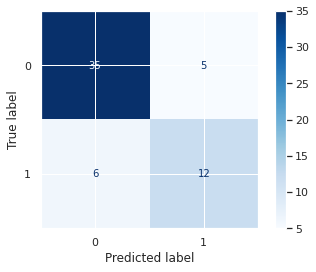

In [87]:
# plot the confusion matrix for the base random forest classifier
plot_confusion_matrix(rf_pipe, X_test, y_test, cmap=plt.cm.Blues)

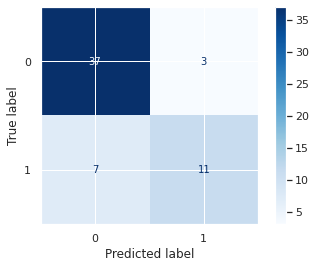

In [88]:
# plot the confusion matrix for the final random forest classifier
plot_confusion_matrix(final_rf, X_test, y_test, cmap=plt.cm.Blues)

### Base Model Evaluation

In [71]:
# create classification report for base random forest classifier training set
print('\nClassification Report for Base Random Forest Classifier Training Set:')
print(classification_report(y_train, y_pred_train_rf, target_names=target_names))

# create classification report for base random forest classifier test set
print('\nClassification Report for Base Random Forest Classifier Test Set:')
print(classification_report(y_test, y_pred_test_rf, target_names=target_names))


Classification Report for Base Random Forest Classifier Training Set:
              precision    recall  f1-score   support

    No Death       1.00      1.00      1.00       158
       Death       1.00      1.00      1.00        73

    accuracy                           1.00       231
   macro avg       1.00      1.00      1.00       231
weighted avg       1.00      1.00      1.00       231


Classification Report for Base Random Forest Classifier Test Set:
              precision    recall  f1-score   support

    No Death       0.85      0.88      0.86        40
       Death       0.71      0.67      0.69        18

    accuracy                           0.81        58
   macro avg       0.78      0.77      0.77        58
weighted avg       0.81      0.81      0.81        58



In [72]:
# plot roc curve for train set
# calculate auc score for train set

# plot roc curve for test set
# calculate auc score for test set

### Final Model Evaluation

In [73]:
# create classification report for final random forest classifier training set
print('\nClassification Report for Final Random Forest Classifier Training Set:')
print(classification_report(y_train, y_pred_train_final_rf, target_names=target_names))

# create classification report for final random forest classifier test set
print('\nClassification Report for Final Random Forest Classifier Test Set:')
print(classification_report(y_test, y_pred_test_final_rf, target_names=target_names))


Classification Report for Final Random Forest Classifier Training Set:
              precision    recall  f1-score   support

    No Death       0.91      0.94      0.93       158
       Death       0.87      0.81      0.84        73

    accuracy                           0.90       231
   macro avg       0.89      0.88      0.88       231
weighted avg       0.90      0.90      0.90       231


Classification Report for Final Random Forest Classifier Test Set:
              precision    recall  f1-score   support

    No Death       0.84      0.93      0.88        40
       Death       0.79      0.61      0.69        18

    accuracy                           0.83        58
   macro avg       0.81      0.77      0.78        58
weighted avg       0.82      0.83      0.82        58



In [74]:
# plot roc curve for train set
# calculate auc score for train set

# plot roc curve for test set
# calculate auc score for test set

#### Analysis
1. pass

## Save The Final Model

In [75]:
# prepare directory for saving model
model_dir = 'models'
model_name_rf = 'rf_model.pkl'
model_name_gbc = 'gbc_model.pkl'

# create directory if it does not exist
Path(model_dir).mkdir(parents=True, exist_ok=True)

# save final random forest classifier model
joblib.dump(final_rf, Path(model_dir) / model_name_rf)

# save final gradient boosting classifier model
joblib.dump(final_gbc, Path(model_dir) / model_name_gbc)

['models/gbc_model.pkl']

# 9. Model Inference

## Load The Model

In [76]:
# model location
model_dir = 'models'
model_name_rf = 'rf_model.pkl'
model_name_gbc = 'gbc_model.pkl'
model_path_rf = Path(model_dir) / model_name_rf
model_path_gbc = Path(model_dir) / model_name_gbc

# load random forest classifier model
rf_model = joblib.load(model_path_rf)

# load gradient boosting classifier model
gbc_model = joblib.load(model_path_gbc)

In [77]:
# display inference set
df_inf.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
0,60.0,1,315,1,60,0,454000.0,1.1,131,1,1,10,1
1,50.0,0,245,0,45,1,274000.0,1.0,133,1,0,215,0
2,70.0,0,232,0,30,0,173000.0,1.2,132,1,0,210,0
3,59.0,1,280,1,25,1,302000.0,1.0,141,0,0,78,1
4,82.0,1,855,1,50,1,321000.0,1.0,145,0,0,30,1


## Inferencing

In [78]:
%%time

# predict inference set using the final random forest classifier model
rf_pred = rf_model.predict(df_inf)

CPU times: user 27.2 ms, sys: 20.2 ms, total: 47.3 ms
Wall time: 28.9 ms


In [79]:
%%time

# predict inference set using the final gradient boosting classifier model
gbc_pred = gbc_model.predict(df_inf)

CPU times: user 9.71 ms, sys: 0 ns, total: 9.71 ms
Wall time: 8.19 ms


In [80]:
# add predictions to inference set
df_inf['rf_pred'] = rf_pred
df_inf['gbc_pred'] = gbc_pred

# display inference set
df_inf

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event,rf_pred,gbc_pred
0,60.0,1,315,1,60,0,454000.0,1.1,131,1,1,10,1,1,1
1,50.0,0,245,0,45,1,274000.0,1.0,133,1,0,215,0,0,0
2,70.0,0,232,0,30,0,173000.0,1.2,132,1,0,210,0,0,0
3,59.0,1,280,1,25,1,302000.0,1.0,141,0,0,78,1,0,0
4,82.0,1,855,1,50,1,321000.0,1.0,145,0,0,30,1,1,1
5,77.0,1,109,0,50,1,406000.0,1.1,137,1,0,209,0,0,0
6,85.0,1,102,0,60,0,507000.0,3.2,138,0,0,94,0,1,1
7,65.0,0,146,0,20,0,162000.0,1.3,129,1,1,7,1,1,1
8,70.0,1,125,0,25,1,237000.0,1.0,140,0,0,15,1,1,1
9,70.0,1,75,0,35,0,223000.0,2.7,138,1,1,54,0,1,1


Model successfully run on inference dataset

# 10. Conclusion

## On EDA
- pass

## On Modeling
- pass

## Modeling TODOS
- pass

# Conceptual Problems

1. Please explain the term Bagging?
    - pass
2. Please explain the difference between the Random Forest algorithm and the boosting algorithm of your choosing
    - pass